Upload '202501_clean2.xlsx' (required). If already exists, you can skip.


Saving 202501_clean2.xlsx to 202501_clean2 (4).xlsx
[INFO] 사용 파일: 202501_clean2 (4).xlsx
[INFO] 원본 컬럼] ['Pump-Begin', 'Pump-End', 'MassResetTime', 'Conc(ug/m3)', 'Cr(ng/m3)', 'Co(ng/m3)', 'Ni(ng/m3)', 'As(ng/m3)', 'Cd(ng/m3)', 'Sb(ng/m3)', 'Pb(ng/m3)']

[PROCESS] Cr(ng/m3) ...
 - N=352, bins=40
 - PLOT: figs/best/Cr_best.png (Student's t, Normal)

[PROCESS] Co(ng/m3) ...
 - N=449, bins=40
 - PLOT: figs/best/Co_best.png (Beta)

[PROCESS] Ni(ng/m3) ...
 - N=326, bins=40
 - PLOT: figs/best/Ni_best.png (Beta)

[PROCESS] As(ng/m3) ...
 - N=449, bins=40
 - PLOT: figs/best/As_best.png (Beta)

[PROCESS] Cd(ng/m3) ...
 - N=449, bins=40
 - PLOT: figs/best/Cd_best.png (Beta)

[PROCESS] Sb(ng/m3) ...
 - N=232, bins=40
 - PLOT: figs/best/Sb_best.png (Weibull)

[PROCESS] Pb(ng/m3) ...
 - N=395, bins=40
 - PLOT: figs/best/Pb_best.png (Gamma)

[DONE] 결과 저장: Tx-적합도_auto.xlsx
[DONE] 그림 저장: figs/best/

[미리보기] Summary_Selected 시트 (상위 10행)


,금속,선정,분포,A-D,K-S P-값,카이제곱 P-값,매개 변수
0,Cr(ng/m3),1,Student's t,1.058021,6.970336e-01,0.002016,"Student's t: 2.45293e+11, 2.96912, 1.61463"
1,Cr(ng/m3),2,Normal,1.058022,6.970342e-01,0.003000,"Normal: 2.96912, 1.61463"
2,Co(ng/m3),1,Beta,1.472066,1.444704e-01,0.000035,"Beta: 1.26998, 2.57259, 1.69662, 18.509"
3,Ni(ng/m3),1,Beta,0.280902,8.587917e-01,0.219998,"Beta: 1.37889, 2.40598, -0.0238187, 8.22503"
4,As(ng/m3),1,Beta,196.651014,3.059701e-162,NaN,"Beta: 0.972299, 1.05039, -9.25774e-25, 2.55021..."
5,Cd(ng/m3),1,Beta,0.789067,6.690238e-01,0.233340,"Beta: 2.20053, 3.14274, 108.747, 256.157"
6,Sb(ng/m3),1,Weibull,1.667011,9.377913e-02,0.088067,"Weibull: 1.26414, -0.123623, 18.6348"
7,Pb(ng/m3),1,Gamma,1.104717,3.941065e-01,0.161594,"Gamma: 1.05733, -0.00169519, 8.45668"


[미리보기] As_best.png


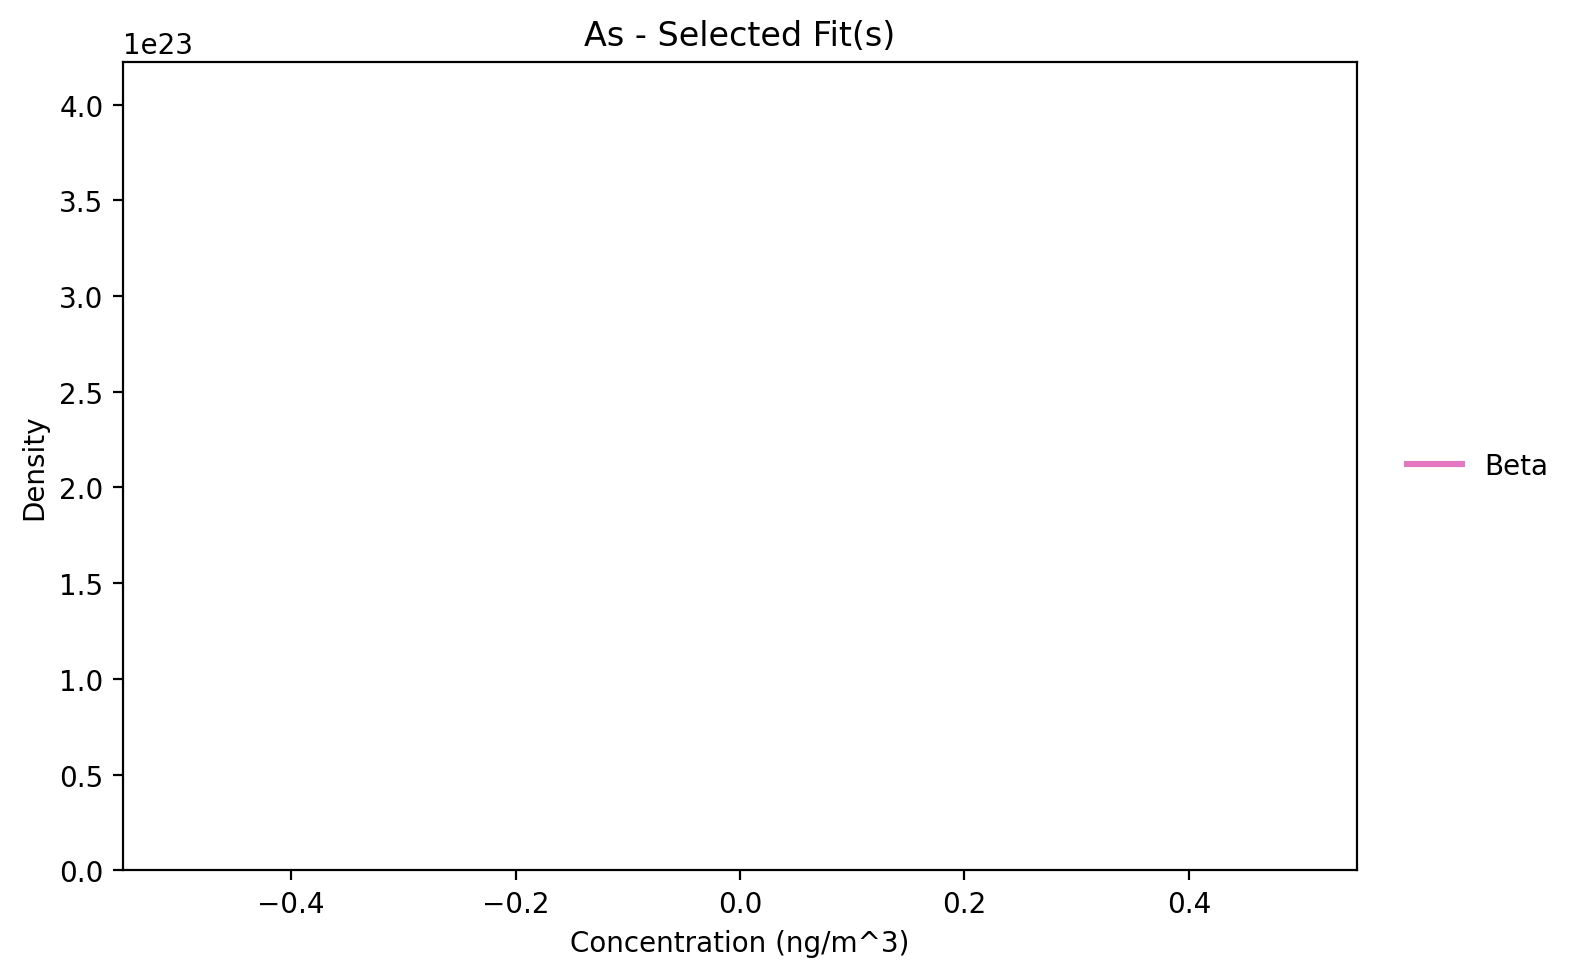

[미리보기] Cd_best.png


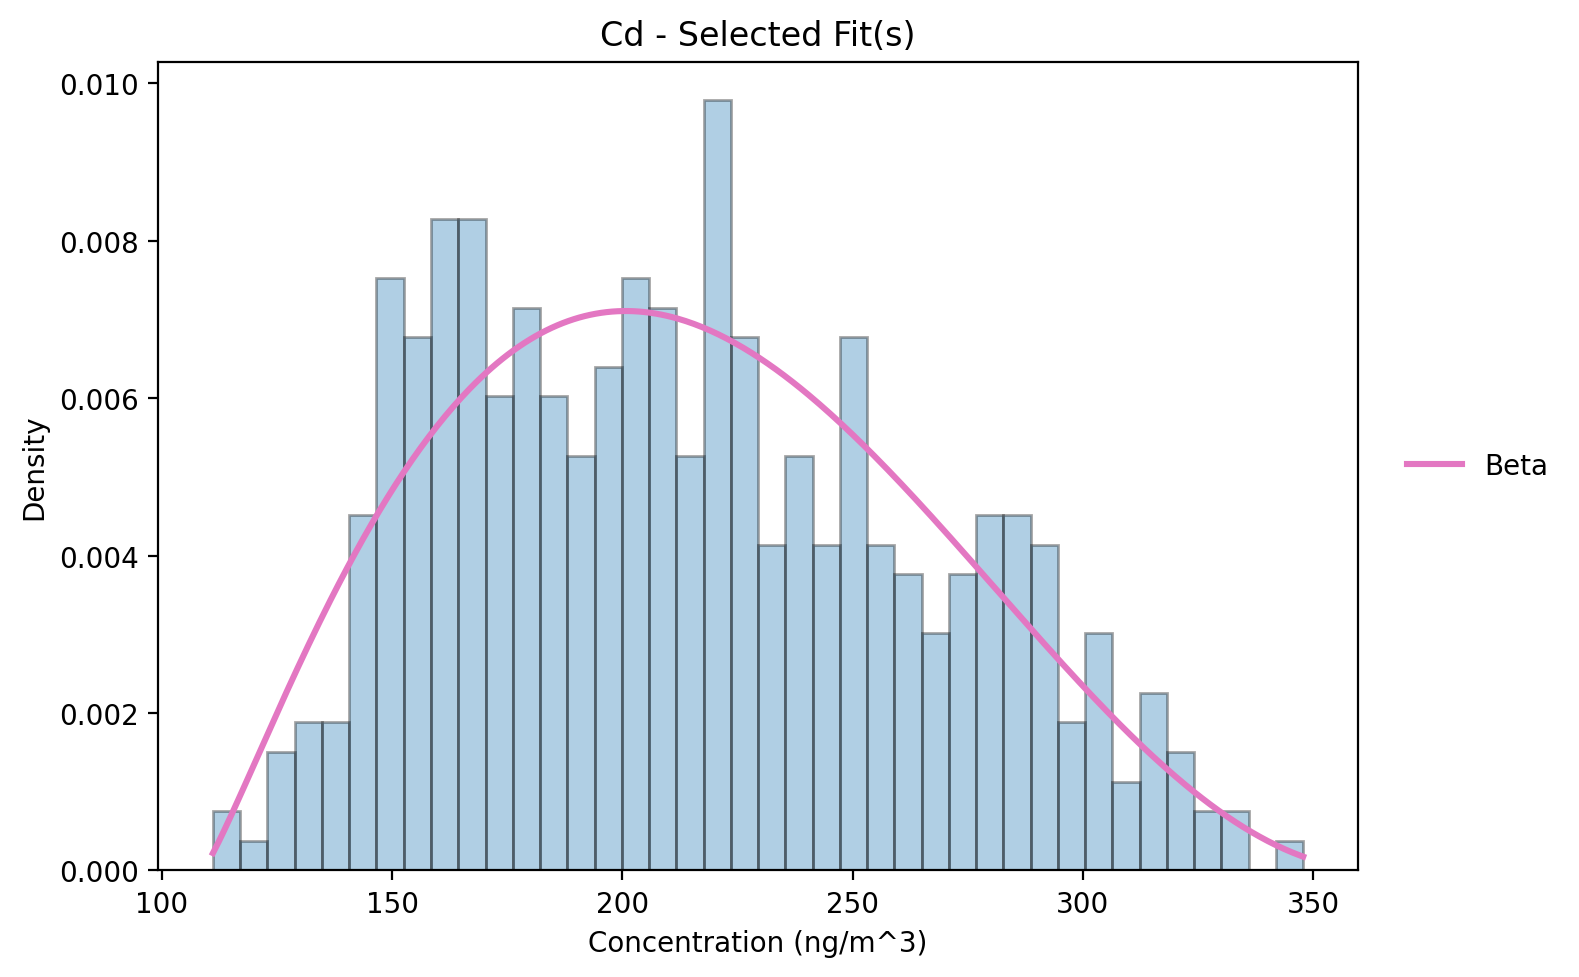

[미리보기] Co_best.png


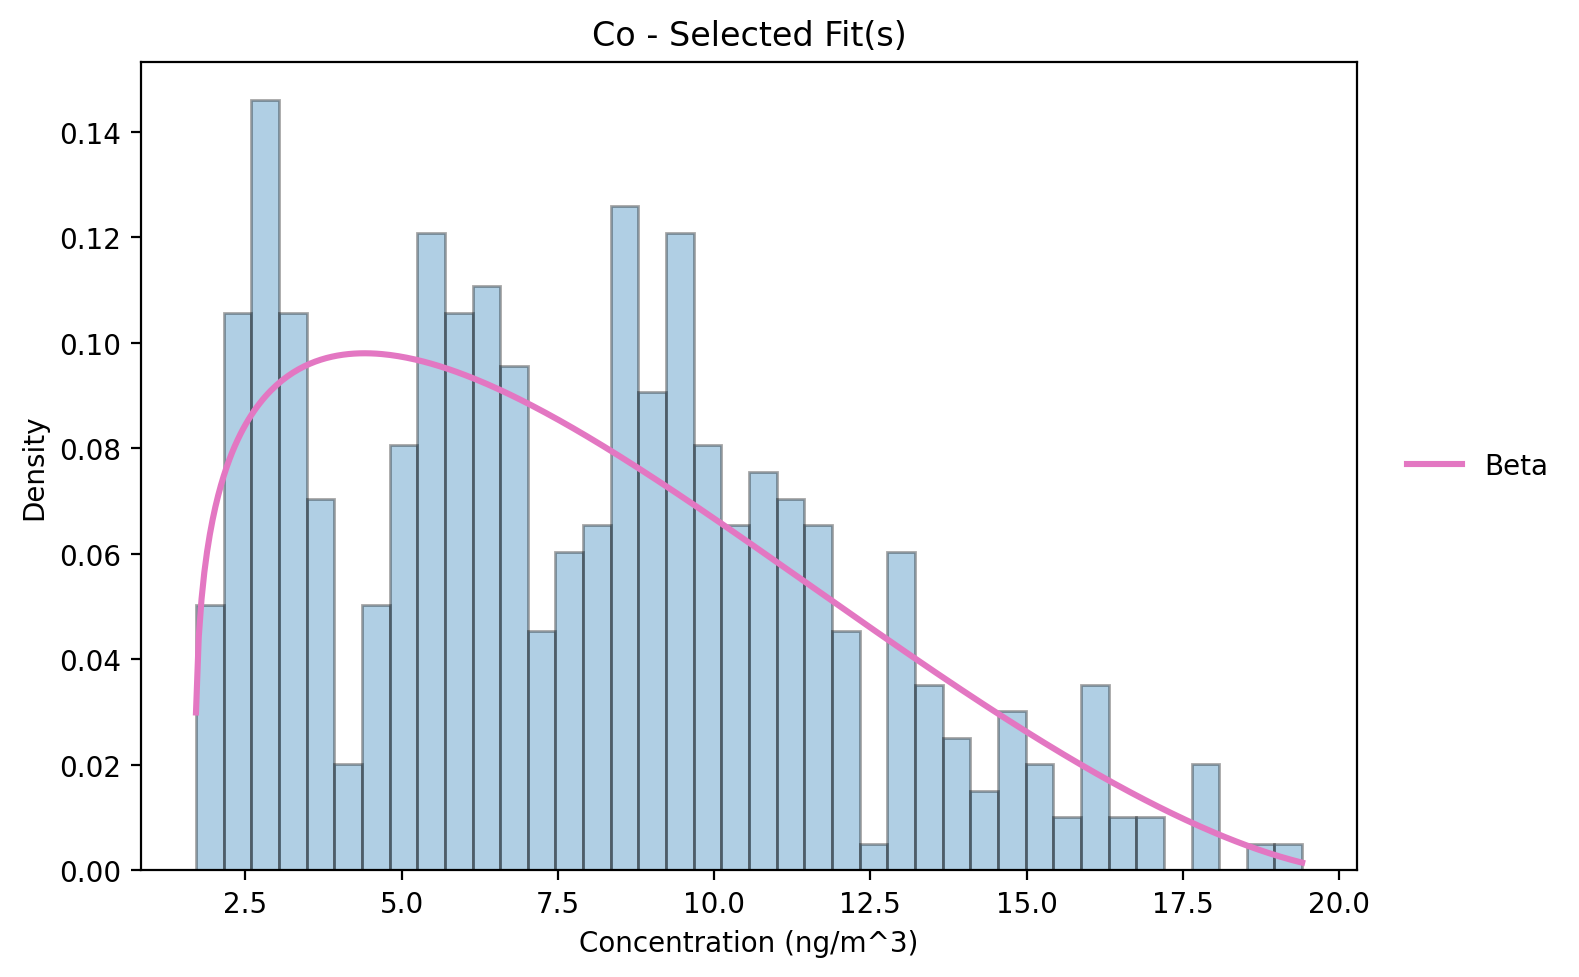

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
# ==============================================
# 14개 분포 적합도 산출 + "최적만 그림(동점/유사 시 복수)"
# Excel 저장 시 engine="openpyxl" 사용 (추가 설치 불필요)
# ==============================================
import numpy as np, pandas as pd, os, math, warnings, re
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import (
    norm, t, logistic, gumbel_r, gumbel_l, weibull_min, beta, gamma,
    lognorm, uniform, expon, triang, pareto
)
from math import isfinite
from collections import OrderedDict
warnings.filterwarnings("ignore")

# ---------- Colab 업로드 ----------
try:
    from google.colab import files
    IN_COLAB = True
    print("Upload '202501_clean2.xlsx' (required). If already exists, you can skip.")
    up = files.upload()
    INPUT_PATH = "202501_clean2.xlsx" if "202501_clean2.xlsx" in up else next(
        (k for k in up.keys() if k.lower().endswith((".xlsx",".xls"))), "202501_clean2.xlsx"
    )
except Exception:
    IN_COLAB = False
    INPUT_PATH = "202501_clean2.xlsx"

print(f"[INFO] 사용 파일: {INPUT_PATH}")

# ---------- 사용자 설정 ----------
TARGET_METALS_ORDER = ["Cr(ng/m3)", "Co(ng/m3)", "Ni(ng/m3)",
                       "As(ng/m3)", "Cd(ng/m3)", "Sb(ng/m3)", "Pb(ng/m3)"]

BINS_MIN, BINS_MAX = 40, 50

AD_PVALUE_MODE = "bootstrap"   # "bootstrap" | "none"
AD_BOOTSTRAP_N = 200
REFIT_ON_BOOTSTRAP = False

# 동점/유사 판정 기준
AD_REL  = 0.02   # A-D 상대 허용비율(2%)
AD_EPS  = 0.01   # A-D 절대 허용치
KS_P_EPS   = 0.02
CHI_P_EPS  = 0.02

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

EXCEL_OUT = "Tx-적합도_auto.xlsx"
DIR_BEST = "figs/best"
os.makedirs(DIR_BEST, exist_ok=True)

# ---------- 유틸/검정 ----------
def _safe_clip(u, eps=1e-12): return np.clip(u, eps, 1-eps)

def anderson_darling_stat(sample, cdf_func):
    x = np.sort(np.asarray(sample)); n = len(x)
    u = _safe_clip(cdf_func(x))
    i = np.arange(1, n+1)
    s = np.sum((2*i-1)*(np.log(u)+np.log(1-u[::-1])))
    return -n - s/n

def ad_pvalue_bootstrap(sample, rv, observed_ad, n_boot=200, refit=False, random_state=None):
    rng = np.random.default_rng(random_state)
    n = len(sample); ge = 0
    for _ in range(n_boot):
        y = rv.rvs(size=n, random_state=rng)
        if refit:
            try:
                params = rv.dist.fit(y)
                rv_b = rv.dist(*params)
            except Exception:
                rv_b = rv
        else:
            rv_b = rv
        try:
            a2_b = anderson_darling_stat(y, rv_b.cdf)
            ge += (a2_b >= observed_ad)
        except Exception:
            pass
    return ge/n_boot if n_boot>0 else np.nan

def choose_bins_fd(x, bins_min=40, bins_max=50):
    x = np.asarray(x); x = x[~np.isnan(x)]
    n = len(x)
    if n < 2: return max(bins_min,1)
    q75,q25 = np.percentile(x,[75,25]); iqr = q75-q25
    if iqr<=0: nb = int(np.sqrt(n))
    else:
        h = 2*iqr*(n**(-1/3)); nb = int(np.ceil((x.max()-x.min())/h)) if h>0 else int(np.sqrt(n))
    return max(bins_min, min(bins_max, nb))

def merge_low_expected(obs_counts, exp_counts, min_exp=5.0):
    obs = obs_counts.astype(float).tolist()
    exp = exp_counts.astype(float).tolist()
    i = 0
    while i < len(exp):
        if exp[i] < min_exp:
            if i == 0 and len(exp)>1:
                exp[i+1]+=exp[i]; obs[i+1]+=obs[i]; del exp[i]; del obs[i]; continue
            elif i == len(exp)-1 and len(exp)>1:
                exp[i-1]+=exp[i]; obs[i-1]+=obs[i]; del exp[i]; del obs[i]; i-=1; continue
            else:
                if exp[i-1] >= exp[i+1]:
                    exp[i-1]+=exp[i]; obs[i-1]+=obs[i]; del exp[i]; del obs[i]; i-=1; continue
                else:
                    exp[i+1]+=exp[i]; obs[i+1]+=obs[i]; del exp[i]; del obs[i]; continue
        i += 1
    return np.array(obs), np.array(exp)

def chisq_gof(sample, rv, bins):
    x = np.asarray(sample)
    hist, edges = np.histogram(x, bins=bins, density=False)
    cdf_vals = _safe_clip(rv.cdf(edges))
    exp = len(x) * np.diff(cdf_vals)
    obs_m, exp_m = merge_low_expected(hist, exp, min_exp=5.0)
    k_params = getattr(rv, "_k_params", 2)
    dof = len(obs_m) - 1 - k_params
    if dof <= 0 or np.any(exp_m<=0): return np.nan, np.nan, len(obs_m), dof
    chi = np.sum((obs_m-exp_m)**2/exp_m)
    return chi, stats.chi2.sf(chi, dof), len(obs_m), dof

def params_to_str(dist_name, params):
    try: return dist_name + ": " + ", ".join([f"{v:.6g}" for v in params])
    except: return dist_name + ": " + str(params)

# ---------- 분포 스펙 ----------
def _mk_rv_with_k(dist, params):
    rv = dist(*params); rv._k_params = len(params); return rv

def fit_normal(x):   p = norm.fit(x);       return p, _mk_rv_with_k(norm, p)
def fit_t(x):        p = t.fit(x);          return p, _mk_rv_with_k(t, p)
def fit_logistic(x): p = logistic.fit(x);   return p, _mk_rv_with_k(logistic, p)
def fit_g_r(x):      p = gumbel_r.fit(x);   return p, _mk_rv_with_k(gumbel_r, p)
def fit_g_l(x):      p = gumbel_l.fit(x);   return p, _mk_rv_with_k(gumbel_l, p)
def fit_weibull(x):  p = weibull_min.fit(x);return p, _mk_rv_with_k(weibull_min, p)
def fit_beta_(x):    p = beta.fit(x);       return p, _mk_rv_with_k(beta, p)
def fit_gamma_(x):   p = gamma.fit(x);      return p, _mk_rv_with_k(gamma, p)
def fit_lognorm(x):  p = lognorm.fit(x);    return p, _mk_rv_with_k(lognorm, p)
def fit_uniform(x):  p = uniform.fit(x);    return p, _mk_rv_with_k(uniform, p)
def fit_expon(x):    p = expon.fit(x);      return p, _mk_rv_with_k(expon, p)
def fit_triang(x):   p = triang.fit(x);     return p, _mk_rv_with_k(triang, p)
def fit_pareto_(x):  p = pareto.fit(x);     return p, _mk_rv_with_k(pareto, p)

def fit_betapert(x):
    x = np.asarray(x); a = float(np.min(x)); b = float(np.max(x))
    if not np.isfinite(a) or not np.isfinite(b) or b<=a:
        raise ValueError("Invalid support for BetaPERT.")
    mu = float(np.mean(x)); m = (6*mu - a - b)/4.0
    eps = 1e-9; m = min(max(m, a+eps), b-eps)
    alpha = 1.0 + 4.0*(m-a)/(b-a); beta_ = 1.0 + 4.0*(b-m)/(b-a)
    p = (alpha, beta_, a, (b-a))
    return p, _mk_rv_with_k(beta, p)

DIST_SPECS = OrderedDict([
    ("Normal", fit_normal),
    ("Student's t", fit_t),
    ("Logistic", fit_logistic),
    ("Maximum Extreme Value", fit_g_r),
    ("Minimum Extreme Value", fit_g_l),
    ("Weibull", fit_weibull),
    ("Beta", fit_beta_),
    ("Gamma", fit_gamma_),
    ("Lognormal", fit_lognorm),
    ("Uniform", fit_uniform),
    ("Exponential", fit_expon),
    ("Triangular", fit_triang),
    ("BetaPERT", fit_betapert),
    ("Pareto", fit_pareto_),
])

COLOR_MAP = {
    "Normal": "#1f77b4", "Student's t": "#ff7f0e", "Logistic": "#2ca02c",
    "Maximum Extreme Value": "#d62728", "Minimum Extreme Value": "#9467bd",
    "Weibull": "#8c564b", "Beta": "#e377c2", "Gamma": "#7f7f7f",
    "Lognormal": "#bcbd22", "Uniform": "#17becf", "Exponential": "#aec7e8",
    "Triangular": "#ffbb78", "BetaPERT": "#98df8a", "Pareto": "#c5b0d5",
}

def evaluate_distribution(x, dist_name, bins_for_chi2):
    fit_func = DIST_SPECS[dist_name]
    out = {
        "분포": dist_name, "A-D": np.nan, "A-D P-값": np.nan,
        "K-S": np.nan, "K-S P-값": np.nan,
        "카이제곱": np.nan, "카이제곱 P-값": np.nan,
        "매개 변수": "", "k_params": np.nan
    }
    try:
        params, rv = fit_func(x)
        out["매개 변수"] = params_to_str(dist_name, params)
        out["k_params"] = getattr(rv, "_k_params", len(params))
        ad = anderson_darling_stat(x, rv.cdf); out["A-D"] = float(ad)
        if AD_PVALUE_MODE == "bootstrap":
            out["A-D P-값"] = float(ad_pvalue_bootstrap(
                x, rv, ad, n_boot=AD_BOOTSTRAP_N, refit=REFIT_ON_BOOTSTRAP, random_state=RANDOM_SEED+123
            ))
        ks = stats.kstest(x, rv.cdf); out["K-S"], out["K-S P-값"] = float(ks.statistic), float(ks.pvalue)
        chi, chi_p, _, _ = chisq_gof(x, rv, bins_for_chi2)
        out["카이제곱"] = float(chi) if isfinite(chi) else np.nan
        out["카이제곱 P-값"] = float(chi_p) if isfinite(chi_p) else np.nan
    except Exception as e:
        out["매개 변수"] = f"{dist_name}: FIT_ERROR - {str(e)[:120]}"
    return out

def rank_key(row):
    AD = row.get("A-D", np.inf)
    KS_p = row.get("K-S P-값", -np.inf)
    CHI_p = row.get("카이제곱 P-값", -np.inf)
    k = row.get("k_params", np.inf)
    return (AD if isfinite(AD) else np.inf,
            -KS_p if isfinite(KS_p) else np.inf,
            -CHI_p if isfinite(CHI_p) else np.inf,
            k if isfinite(k) else np.inf,
            row.get("분포","~"))

def pick_best_or_ties(res_df):
    res_df["__key__"] = res_df.apply(rank_key, axis=1)
    res_df = res_df.sort_values("__key__").reset_index(drop=True)
    best = res_df.iloc[0]
    best_key = best["__key__"]; best_ad = best["A-D"]; best_ks_p = best["K-S P-값"]; best_chi_p = best["카이제곱 P-값"]
    tied = res_df[res_df["__key__"].apply(lambda k: k==best_key)]
    def is_similar(row):
        if not (np.isfinite(row["A-D"]) and np.isfinite(best_ad)): return False
        ad_close = (abs(row["A-D"]-best_ad) <= max(AD_EPS, AD_REL*abs(best_ad)))
        ks_close = (np.isnan(row["K-S P-값"]) or np.isnan(best_ks_p)) or (abs(row["K-S P-값"]-best_ks_p) <= KS_P_EPS)
        chi_close = (np.isnan(row["카이제곱 P-값"]) or np.isnan(best_chi_p)) or (abs(row["카이제곱 P-값"]-best_chi_p) <= CHI_P_EPS)
        return ad_close and ks_close and chi_close
    similar = res_df[res_df.apply(is_similar, axis=1)]
    chosen = pd.concat([tied, similar]).drop_duplicates().reset_index(drop=True)
    return chosen, res_df

def plot_selected(x, rv_map, bins, names, title, outfile):
    fig, ax = plt.subplots(figsize=(8,5))
    ax.hist(x, bins=bins, density=True, alpha=0.35, edgecolor="k")
    xs = np.linspace(np.min(x), np.max(x), 400)
    for name in names:
        rv = rv_map.get(name);
        if rv is None: continue
        try:
            ax.plot(xs, rv.pdf(xs), lw=2.2, label=name, color=COLOR_MAP.get(name))
        except Exception: pass
    ax.set_xlabel("Concentration (ng/m^3)")
    ax.set_ylabel("Density")
    ax.set_title(title)
    ax.legend(loc="center left", bbox_to_anchor=(1.02,0.5), frameon=False)
    plt.tight_layout()
    plt.savefig(outfile, dpi=200, bbox_inches="tight"); plt.close()

# ---------- 실행 ----------
df = pd.read_excel(INPUT_PATH)
print("[INFO] 원본 컬럼]", list(df.columns))
metals_available = [c for c in TARGET_METALS_ORDER if c in df.columns]
if not metals_available: raise ValueError("금속 컬럼이 없습니다.")

# 변경 부분: openpyxl 사용
writer = pd.ExcelWriter(EXCEL_OUT, engine="openpyxl")
summary_rows = []

for metal_col in metals_available:
    print(f"\n[PROCESS] {metal_col} ...")
    x = df[metal_col].astype(float).replace([np.inf,-np.inf], np.nan).dropna().values
    n = len(x)
    if n < 10:
        print(f" - 표본 n={n} (skip)")
        continue
    bins = choose_bins_fd(x, BINS_MIN, BINS_MAX)
    print(f" - N={n}, bins={bins}")

    rows, rv_cache = [], {}
    for dname, fit_func in DIST_SPECS.items():
        res = evaluate_distribution(x, dname, bins)
        rows.append(res)
        try:
            p, rv = fit_func(x); rv_cache[dname] = rv
        except Exception: pass

    res_df = pd.DataFrame(rows, columns=[
        "분포","A-D","A-D P-값","K-S","K-S P-값","카이제곱","카이제곱 P-값","매개 변수","k_params"
    ])

    chosen, ranked = pick_best_or_ties(res_df.copy())
    ranked_clean = ranked.drop(columns=["__key__"])
    sheet_name = re.sub(r"[^A-Za-z0-9]+","_", metal_col)[:31]
    ranked_clean.index = np.arange(1, len(ranked_clean)+1)
    ranked_clean.to_excel(writer, sheet_name=sheet_name, index=True)

    for idx, row in chosen.iterrows():
        summary_rows.append({
            "금속": metal_col, "선정": idx+1, "분포": row["분포"],
            "A-D": row["A-D"], "K-S P-값": row["K-S P-값"],
            "카이제곱 P-값": row["카이제곱 P-값"], "매개 변수": row["매개 변수"]
        })

    names = list(chosen["분포"].values)
    title = f"{metal_col.replace('(ng/m3)','')} - Selected Fit(s)"
    outfile = os.path.join(DIR_BEST, f"{metal_col.replace('(ng/m3)','')}_best.png")
    plot_selected(x, rv_cache, bins, names, title, outfile)
    print(f" - PLOT: {outfile} ({', '.join(names)})")

if summary_rows:
    summary_df = pd.DataFrame(
        summary_rows,
        columns=["금속","선정","분포","A-D","K-S P-값","카이제곱 P-값","매개 변수"]
    )
    summary_df["__order__"] = summary_df["금속"].apply(lambda c: metals_available.index(c))
    summary_df = summary_df.sort_values(["__order__","선정"]).drop(columns="__order__")
    summary_df.to_excel(writer, sheet_name="Summary_Selected", index=False)

# <= 여기까지가 요약 저장. 아래 두 줄이 누락됐습니다.
writer.close()
print(f"\n[DONE] 결과 저장: {EXCEL_OUT}")
print(f"[DONE] 그림 저장: {DIR_BEST}/")

# =======================================
import IPython.display as disp
import glob

# 엑셀 요약표 표시
print("\n[미리보기] Summary_Selected 시트 (상위 10행)")
try:
    preview = pd.read_excel(EXCEL_OUT, sheet_name="Summary_Selected")
    disp.display(preview.head(10))
except Exception as e:
    print("요약 시트 로드 실패:", e)

# 그림 몇 개 미리보기 (Cr, Co, Ni 우선)
sample_imgs = sorted(glob.glob(os.path.join(DIR_BEST, "*.png")))
for img in sample_imgs[:3]:
    print(f"[미리보기] {os.path.basename(img)}")
    disp.display(disp.Image(filename=img))

from google.colab import files

files.download(EXCEL_OUT)
